# Building an image classifier with a DNN using TensorFlow



## About This Session

This lab is a guided walkthrough to build a _basic_ 'image classification' DNN model and train it on some data.

As we build up our model we will build a familiarity with the various components and strategies for building such an ANN system.

After we have been able to do this we will then save and load our now-trained model from disk and use it to make a prediction on a new image which isn't present in the original dataset.


_Responsible: Robert Currie (<rob.currie@ed.ac.uk>)_

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
 - Notebooks should be submitted by **10am on Friday 13th October**
 - This notebook starts with problem 0. This is not assessed, but it is a helpful exercise to show some of the potential pitfalls of 'trusting algorithms' to do the work for us.

* There are 10 sections involved in building a DNN using TensorFlow, trainig it on data and then using it to predict based on a new piece of data never seen by the model before.
* There are 2 bonus sections covering 'additional training of a model' and 'the impact of training on the distribution of internal weights within a DNN'. These have bonus points if you manage to finish them, but the final mark is capped at 10.


##### Marking

Marks for the different parts are shown below.

* Questions are marked as starting with '**Q**' and can in principle be attempted at any time.
* Problems are intended to be tackled in order, i.e. 1->9
* If you jump in at problem 5 for instance you won't yet have a model to train without tackling the steps before.
* There are bonus problems at the end to tackle but the maximum mark is 10/10

| <p align='left'> Title                         | <p align='left'> Parts | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 0. Dangers of Fitting                  | <p align='left'>  3  | <p align='left'> 0 |
| <p align='left'> 1. Vizualizing the Data                | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 2. Formatting Input Data               | <p align='left'>  3  | <p align='left'> 1 |
| <p align='left'> 3. Building a DNN model                | <p align='left'>  2  | <p align='left'> 1 |
| <p align='left'> 4. Understanding our model             | <p align='left'>  5  | <p align='left'> 2 |
| <p align='left'> 5. Training our model                  | <p align='left'>  2  | <p align='left'> 1 |
| <p align='left'> 6. Understanding the training history  | <p align='left'>  3  | <p align='left'> 1 |
| <p align='left'> 7. Making a Prediction                 | <p align='left'>  2  | <p align='left'> 1 |
| <p align='left'> 8. Testing the model                   | <p align='left'>  2  | <p align='left'> 1 |
| <p align='left'> 9. Making Predictions with new data    | <p align='left'>  2  | <p align='left'> 1 |
| <p align='left'> **Bonus 1:** Analyzing Weights         | <p align='left'>  5  | <p align='left'> 1 |
| <p align='left'> **Bonus 2:** Loading a model and optimizing it further | <p align='left'>  7  | <p align='left'> 1 |
| <p align='left'> **Total** | | <p align='left'> max **10** |


In [1]:
# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
# if you need to force tensorflow to use your CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# imports for array-handling and plotting
import numpy as np
from numpy import argmax
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mtick

# Importing tensorflow so we can access anything later
import tensorflow as tf

# keras imports for importing our dataset
from tensorflow.keras.datasets import mnist
# keras imports for building our neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Dense, Activation
# keras import for manipulating some of our data
from tensorflow.keras.utils import to_categorical

# keras tools for loading an image from disk
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# keras tools for loading an ANN model from disk
from tensorflow.keras.models import load_model


# Problem 0: Understanding Fitting

### Problems when fitting (an interlude)

When fitting to a dataset we trust that the algorithm that we're using will find the correct minima and that the fit hasn't become pronned to some problem such as vanishing gradients.

Here we're going to demonstrate a quick example of problems that you can hit with a fit failing to converge.

There are many tools/checks in place in most modern libraries to help fix common problems, but we will explicitly use the `SLSQP` method here which allows us to look at narrow ranges of a full function.

`result = minimize(objective, pt, method='SLSQP', jac=derivative, bounds=[(...),])`

The objective function of this fit has been provided it is the equation of the form `y=x^4-5x^2+0.1x` .

This function has 3 points where the gradient is zero and has 2 minima, a global minima and a local minima.

## 0.1 Provide the derivative function for this 1D method (this is the Jacobian)

This is just a case of returning the correct value from the derivative method.

In [2]:
from scipy.optimize import minimize

def objective(x):
  return x[0]**4 - 5*x[0]**2 + 0.1*x[0]

# Part 1 complete the derivative function
def derivative(x):
  return 4*x[0]**3 - 10*x[0] + 0.1

## 0.2 Run the minimize method over given ranges and identify the 3 'stable' points of the function

Run the minimize method over these 3 ranges:

| <p align='left'> Ranges |
| :--- |
| ` (0.1, 5.0)` |
| ` (0.0, 5.0)`  |
| `(-5.0, 5.0)` |


In [3]:
pt = (5.,)
ranges = [(0.1, 5.0),  (0.0, 5.0),  (-5.0, 5.0)]

# Part 2 perform 3 minimizations
result_1 = minimize(objective, pt, method='SLSQP', jac=derivative, bounds=[ranges[0]])
result_2 = minimize(objective, pt, method='SLSQP', jac=derivative, bounds=[ranges[1]])
result_3 = minimize(objective, pt, method='SLSQP', jac=derivative, bounds=[ranges[2]])

## 0.3 Identify the true minima of the function

##### Hint:
    
Running `scipy.minimize` returns an object containing the fit result and a bunch of extra output.
The value of `x` from a 'minimize' after it has finished running can be accessed via `result['x']` and the function value can be accessed via `result['fun']`.

In [4]:
print('Minimum 1: {}'.format(result_1['x']))
print('Minimum 2: {}'.format(result_2['x']))
print('Minimum 3: {}'.format(result_3['x']))

print('Result 1: {}'.format(result_1['fun']))
print('Result 2: {}'.format(result_2['fun']))
print('Result 3: {}'.format(result_3['fun']))

allRes = (result_1['fun'], result_2['fun'], result_3['fun'])
# Part 3 identify the true minima
print('Best Result is: Result {1} = {0}'.format(np.min(allRes), np.argmin(allRes)) ) 

Minimum 1: [1.57609448]
Minimum 2: [0.]
Minimum 3: [-1.5861131]
Result 1: -6.092136908469087
Result 2: 0.0
Result 3: -6.4083630973486665
Best Result is: Result 2 = -6.4083630973486665


# Load & Visualize the dataset

#### Loading the data

The data we're using comes from the well use mnist dataset which has been around since the 80s and is something people new to AI/ML often try their hand at building models for.

###### About the data
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

This dataset consists of many pixelated digitized images of hand-written numbers.
These images contain data in a single channel i.e. black and white images. White images on a Black background.


We've loaded the mnist class and we just need to call `load_data` to get the dataset in order for us to use this data.

This method returns 2 tuples. The training data and labels as well as the test data and labels.

In [5]:
# Load the Training and Test data
(X_train, Y_train), (X_test, Y_test) =  mnist.load_data(path='mnist.npz')

# Visualize the dataset

It's important to understand the data that you're trying to train on. In most cases preparing the data in some way that it's suitable for training is the most time consuming part of building and training a model to be useful.

# Problem 1: Understanding the input data

Now that we've loaded the data we need to make sure that it's in a format that we can use.

## 1.1 First, What is the shape of an individual image?
Firstly, what is the shape of the each input image?, and what range of values do the individual pixels within the image take?

In [6]:
X_train = img_to_array(X_train)
print('The shape of each image is {}'.format(np.shape(X_train[0])))

The shape of each image is (28, 28)


In [7]:
print('The image takes in values between {1} to {0} which is RGB colouring.'.format(np.max(X_train), np.min(X_train)))

The image takes in values between 0.0 to 255.0 which is RGB colouring.


## 1.2 Plotting some of the input data

Secondly, we should attempt to plot some of the input data to our fit to understand what the data looks like.
It is possible to use the pyplot method to plot the images which we have just loaded into tensors.

##### Hint:
The options of `cmap='gray', interpolation='none'` with `pyplot.imshow` show the images as we would expect to see them.

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html


#### Plot the Data

###### Plot the first 2 values from the training portion of the dataset using the values to the first 2 training labels as labels.

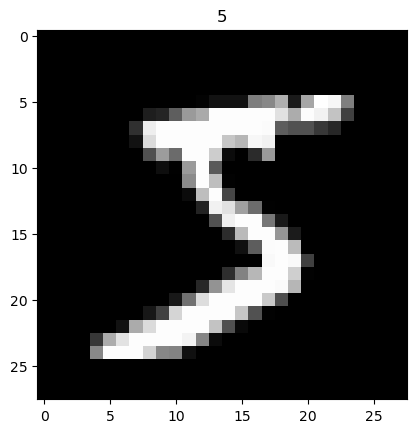

In [8]:
plt.imshow(X_train[0], cmap='gray', interpolation=None)
plt.title(Y_train[0])
plt.show()

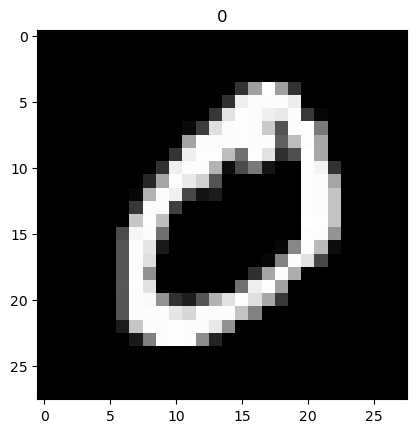

In [9]:
plt.imshow(X_train[1], cmap='gray', interpolation=None)
plt.title(Y_train[1])
plt.show()

# Normalizing and Formatting the dataset

Before we begin fitting the dataset it is useful to make sure that the data is in a format that we can use for fitting.



## Problem 2: Formatting Input Data


### 2.1 Normalize and reformat our Input Data.

For our model we're going to use a flat array of 768 pixel values as our input and we want to make sure that our data has been correctly normalized so that the values are all in the unitary range [0,1].

The data should be converted to the `'float32'` using the `astype` method and then normalized to have values between 0 and 1.

In [10]:
# convert data into a float from an integer array
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# normalizing the data to help with the training
X_train /= np.max(X_train)
X_test /= np.max(X_test)

## 2.2 Resize the input data
The input data should be re-formatted such that we have 1 flat array of inputs for each image.

i.e. we have 60,000 images for training, we want each of these images to contain data in a flat array which means we are going from a 3D tensor to a 2D tensor. e.g. `(60000, 10, 10) ==> (60000, 100)` 

##### Hint: Tensor.Reshape can be used to simplify the re-shaping/re-sizing of the input data

In [11]:
## building the input 1D vector from the 28x28 pixels
shape = np.shape(X_train)
X_train = tf.reshape(X_train, [shape[0], (shape[1]*shape[2])])
print(np.shape(X_train))

shape = np.shape(X_test)
X_test = tf.reshape(X_test, [shape[0], (shape[1]*shape[2])])
print(np.shape(X_test))

(60000, 784)
(10000, 784)


## 2.3 Change our input labels for fitting

Now we need to make sure that the dataset labels are in a format which we can use alongside the training and testing dataset.

Typically DNN expect category labels to be in a one-hot encoding. This means that labels are vectors with a single entry of 1 and all other entries being 0. 

##### Hint: This can be achieved using the `to_categorical` utility function in Keras.

Using this change the Y_test and Y_train labels to be cateory labels.

If you want to be explicit we know we're working with `n_classes = 10` due to looking at the numerical characters `0...9`.

In [12]:
n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)

Y_train = to_categorical(Y_train, num_classes=n_classes)
Y_test = to_categorical(Y_test, num_classes=n_classes)

Shape before one-hot encoding:  (60000,)


In [13]:
print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


# Problem 3: Building the DNN


In Tensorflow a 'standard' DNN model is defined using the Sequential model.
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Then additional layers are added to the model one at a time until the model is complete using `model.add`.


## Build a DNN with 2 "hidden layers"

You should build a DNN such that it has 2 hidden and 1 output layer. When building a model we have neurons and activation functions. These are 'layers' in TensorFlow but we want 3 layers with neurons and activators such as: 

| <p align='left'> Layer |
| :--- |
| Dense |
| Activation |
| Dense |
| Activation |
| Dense |
| Activation |

A flat layer of neurons is defined using the `Dense` layer in Tensorflow.
For our example we want to keep our Activators and our layers of neurons separate.
    
We want to use a random flat distribution of weights when initializing the parameters in this fit,
    
### !!Use the parameters `use_bias=True, kernel_initializer='RandomUniform'` when constructing a layer of neurons!!

###### NB: By default each Dense layer also applies a bias to each node to improve the fit performance.
    
For our hidden nodes we want to use the `'GELU'` Activator for this example and `'softmax'` to build our a numerical classifier.

In [14]:
n_categories = 10
n_nodes = 256
activation_type = 'gelu'
weight_start_values = 'RandomUniform'

# building a linear stack of layers with the sequential model
model = Sequential()

model.add(Dense(n_nodes, use_bias=True, kernel_initializer='RandomUniform'))
model.add(Activation(activation_type))
model.add(Dense(n_nodes, use_bias=True, kernel_initializer='RandomUniform'))
model.add(Activation(activation_type))
model.add(Dense(n_categories, use_bias=True, kernel_initializer='RandomUniform'))
model.add(Activation('softmax'))

## Compiling our model

At this point we have a description of our model. Now we want to compile it.

Strictly speaking some of the steps here are optional, but we want to be explicit with how we're building our model to be sure that we've understood everything that is going on.

We will be using `categorical_crossentropy` as discussed in our lecture as our loss model.

We will also be using the `Stochastic Gradient Descent` or `SGD` optimizer for our training. This is different to the default.

`metrics=['accuracy']` is also passed to our model to ensure that it collects training data that we're interested in later on.


## Now compile and build the model

In [15]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='SGD')
# Now we want to 'build' the model, so tell it about our input data format
model.build(input_shape=(1,784))

# Print a helpful summary of our model
model.summary()

# Now we're going to take a copy of the weights in our first hidden layer of the fit
weights_before_training = model.layers[0].get_weights()[0].copy()
weights_before_training.resize(200704)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 256)                  200960    
                                                                 
 activation (Activation)     (1, 256)                  0         
                                                                 
 dense_1 (Dense)             (1, 256)                  65792     
                                                                 
 activation_1 (Activation)   (1, 256)                  0         
                                                                 
 dense_2 (Dense)             (1, 10)                   2570      
                                                                 
 activation_2 (Activation)   (1, 10)                   0         
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trai

# Problem 4: Understanding our model

## Q: 4.1

##### Using an Input Shape of `784` and a hidden layer of `256` nodes you should see `200960` free parameters in the first layer of your model.

##### Explain where this number of free parameters comes from.



### Answer: This is the number of input parameters times the number of nodes. There is also the count of the free parameters that comes from the bias which the function has recognised and this addtional value is added to the total parameters.
### (789 x 256) + 256 = 200960

## Q: 4.2

##### Using `256` nodes per hidden layer there will also be `65792` weights between the 2 hidden layers in the model.

##### Explain where these weights come from.

### Answer: This is the total number of free parameters plus the bias between the hidden layes that have 256 nodes each. Therefore,
### (256 x 256) + 256 = 65792

## Q: 4.3

##### Explain why a `'softmax'` activation function is used at the end of our classification model.

### Answer: In the final activation of the model, 'softmax' is used to calculate the probability at each of the the nodes in the final dense layer.

## Q: 4.4

##### How many weights would we expect in the whole model when using 128 neurons per hidden layer?

### Answer: The hidden layers will have the total number of free parameter between all the nodes including the bias.
### (128 x 128) + 128 = 16512
### There will be 16,512 weights between the hidden layers.

## Q: 4.5

##### Why are activation functions needed in a DNN which is trained on data?

### Answer: Activator functions are used to allow the neural networks to learn complex patterns of data and to help guide the neural network in deciding what should be transmitted in the next neuron. It also helps the neural network understand non-linear relationships.


# Problem 5: Train the model

### Model Training

Now that we have a model we want to fit we now want to train it on our training dataset making sure to use our validation data to check on our training.

The result of this training will be stored in our history and will allow us to go back and asses how well our training worked.


## 5.1 Perform the training
Complete and run the command below to train the model on data using a `batch_size` of 600 for 100 `epochs`.


In [16]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=2,
          batch_size = 600,
          epochs = 100
          )

## Now take a copy of the weights in the first hidden layer _after_ training on data
weights_after_training = model.layers[0].get_weights()[0].copy()
weights_after_training.resize(200704)

Epoch 1/100


100/100 - 2s - loss: 2.2982 - accuracy: 0.1392 - val_loss: 2.2923 - val_accuracy: 0.2845 - 2s/epoch - 17ms/step
Epoch 2/100
100/100 - 1s - loss: 2.2873 - accuracy: 0.3810 - val_loss: 2.2807 - val_accuracy: 0.4577 - 653ms/epoch - 7ms/step
Epoch 3/100
100/100 - 1s - loss: 2.2752 - accuracy: 0.4756 - val_loss: 2.2673 - val_accuracy: 0.5139 - 628ms/epoch - 6ms/step
Epoch 4/100
100/100 - 1s - loss: 2.2606 - accuracy: 0.5221 - val_loss: 2.2505 - val_accuracy: 0.5299 - 624ms/epoch - 6ms/step
Epoch 5/100
100/100 - 1s - loss: 2.2414 - accuracy: 0.5248 - val_loss: 2.2275 - val_accuracy: 0.5233 - 605ms/epoch - 6ms/step
Epoch 6/100
100/100 - 1s - loss: 2.2140 - accuracy: 0.5024 - val_loss: 2.1933 - val_accuracy: 0.4877 - 627ms/epoch - 6ms/step
Epoch 7/100
100/100 - 1s - loss: 2.1718 - accuracy: 0.4608 - val_loss: 2.1393 - val_accuracy: 0.4526 - 589ms/epoch - 6ms/step
Epoch 8/100
100/100 - 1s - loss: 2.1049 - accuracy: 0.4448 - val_loss: 2.0560 - val_accuracy: 0.4607 - 580ms/epoch - 6ms/step
Epoch 

## Q: 5.2

##### Why are there 100 steps per epoc in this training? (0.5 marks)

### Answer: This number represents the number of iterations that the model does to train the dataset. The batchsize parameter is set to 600 and there is 60,000 images in total. This means that:
### 60,000 images / (600 images / step) = 100 steps.


# Problem6: Understanding the training history

### Cross-Checking our Model fit

The returned history from our fit contains both the accuracy and the loss function over the epocs of training.

This information can be accessed via: `history.history[]`

We now want to make 2 plots:


## 6.1 Plotting Evolution of model Accuracy

This plot will show how the accuracy of the model has increased vs epocs of training.

This should show for a good model that accuracy increases with the number of epocs.

###### Hint:
`history.history[accuracy]` vs `history.history[val_accuracy]` give the model accuracy during the training epocs.

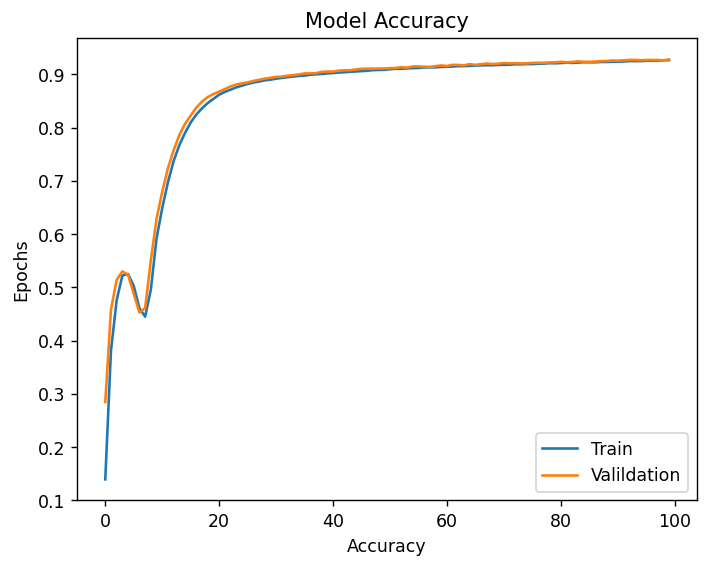

In [17]:
accuracy_training = history.history['accuracy']
accuracy_test = history.history['val_accuracy']

plt.title('Model Accuracy')
plt.plot(accuracy_training, label='Train')
plt.plot(accuracy_test, label='Valildation')
plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Accuracy')
plt.gcf().set_dpi(125)

## 6.2 Plotting Evolution of model losses

As above, but now we want to see how the loss function evolves using the `loss` vs `val_loss` parameters vs epoc.

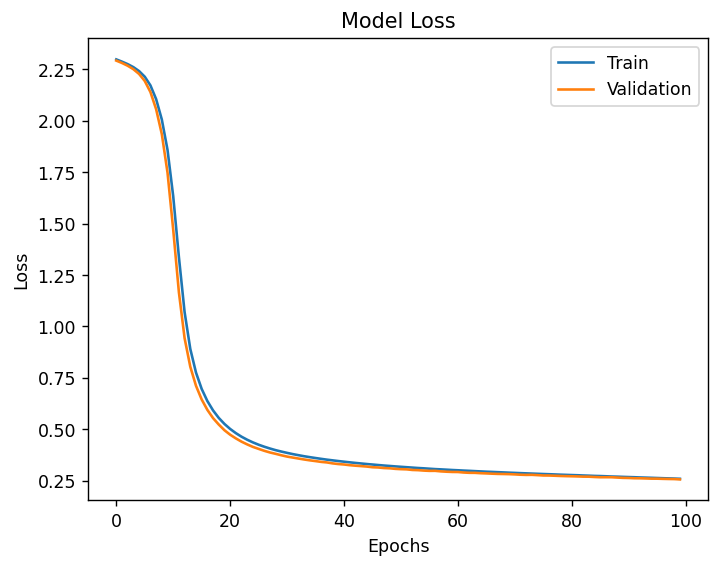

In [18]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.title('Model Loss')
plt.plot(training_loss, label='Train')
plt.plot(test_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gcf().set_dpi(125)

## Q 6.3: Is this model over-training?

### Answer: The Model is not being over-trained since, the shape of the curves match in shape and curves do not stray away from each other.


# Problem 7: Making predictions

### Testing how well our model classifies different numbers

In order to test how well our model actually classifies different numbers we need to be able to make predictions using it.

Our model is designed to output the probability of each label being true (according to the model).

With that in mind we want to get the best value from a single image.


Our model has been defined to take an input of shape `(1, 784)`. This allows us to pass many images at a time to the model to either train or to have predictions made on.


## 7.1 Predicting with our model

### Want to make a prediction using the 10th element of the testing dataset

Lets first make a single prediction using our dataset and model.

To do this we need to:

1. Take the 10th element from our test dataset
2. Resize this to match the expected input dimensions from our model
3. Make a prediction using this input using `model.predict`
4. Make a bar chart showing the predictions from the model.

###### Hint: `plt.bar` is useful for plotting the output

In [19]:
prediction = model.predict(np.array([X_test[9]]))

1/1 [==============================] - 0s 134ms/step


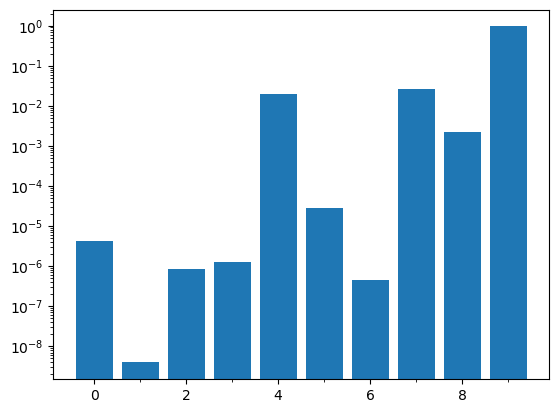

In [20]:
plt.bar(np.linspace(0, 9, 10), prediction[0])
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.yscale('log')

## 7.2 Making a Numerical Prediction

The method `argmax` from numpy can help us change this prediction distribution from a vector to a single value.

### Predict the number in this image ###

In [21]:
np.argmax(prediction[0])

9

# Problem 8 Testing the model

One of the ways we can evaluate how well our model is spearating our input data we can build a confusion matrix.

This allows us to see how many numbers are incorrectly identified using a labelled dataset.

## Constructing a Confusion Matrix

In order to construct a confusion matrix we need to make predictions over a large number of inputs and be able to compare them to labels which are known to be correct.

Taking the 'training' dataset can collect numerical predictions using `argmax` for each of the 60,000 entries in the dataset.

## 8.1 Make many predictions

To collect enough data to produce our confusion matrix we can make predictions over the whole training (or test) dataset.

In [22]:
predics = model.predict(X_train)

  50/1875 [..............................] - ETA: 8s 

1875/1875 [==============================] - 4s 2ms/step


## 8.2 Plot Confusion Matrix

We can now construct a confusion matrix using `tf.math.confusion_matrix` and plot it with `sns.heatmap`.

In [23]:
Y_train = np.array([np.argmax(Y_trainset) for Y_trainset in Y_train])
predics_Val = np.array([np.argmax(predlist) for predlist in predics])

<Axes: >

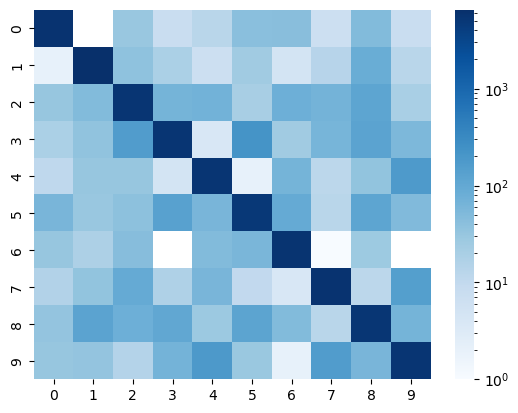

In [24]:
# Create the confusion matrix
confusion_matrix = tf.math.confusion_matrix(Y_train, predics_Val)

# Import the useful tools for plotting a confusion matrix
import seaborn as sns
from matplotlib.colors import LogNorm

# Plot the confusion matrix using a heatmap
sns.heatmap(confusion_matrix, annot=False, cmap='Blues', norm=LogNorm())

# 9: Making Predictions with new data

Make aure that you download the sample image 

## 9.1 Load data from `sample_image.png`

Complete the load_image method below to load a new numerical image file from disk, resize and normalize the data into a format which we can use with our model.

In [25]:
# load and prepare the image
def load_image(filename):
 # load the image
 #img = load_img(filename, target_size=(28, 28), color_mode='grayscale')
 img = load_img(filename, target_size=(28, 28), color_mode='grayscale')
 
 # convert to array
 img = img_to_array(img)
 img = np.array([img.flatten()])
 img /= np.max(img)

 return img

# load the image
img = load_image('sample_image.png')

## 9.2 Make a prediction on the new data

Now that we've loaded the sample file, use our model to make a prediction on this data.

1/1 [==============================] - 0s 29ms/step
Prediction: 3


Text(0, 0.5, 'Probability')

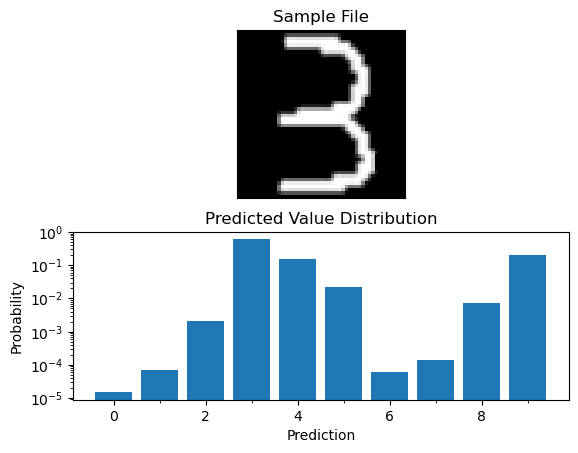

In [26]:
# predict the class
predict_value = model.predict(img)
digit = argmax(predict_value)
print('Prediction: {}'.format(digit))

fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(mpimg.imread('sample_image.png'), cmap='gray', interpolation='none')
plt.title("Sample File")
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)

plt.bar(np.linspace(0, 9, 10), predict_value[0])
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.yscale('log')
plt.title("Predicted Value Distribution")
plt.xlabel('Prediction')
plt.ylabel('Probability')

# Bonus 1: Analyzing Weights

Before and after fitting our model we took copies of the weights used in training our dataset.

If you construct a histogram of the weights from before fitting what distribution does it follow?

## B1.1 Plot weights from before training

(array([19816., 19965., 19941., 20173., 20278., 20016., 19898., 20291.,
        20187., 20139.]),
 array([-4.99998704e-02, -3.99998873e-02, -2.99999043e-02, -1.99999232e-02,
        -9.99994017e-03,  4.28408384e-08,  1.00000259e-02,  2.00000089e-02,
         2.99999900e-02,  3.99999730e-02,  4.99999560e-02]),
 <BarContainer object of 10 artists>)

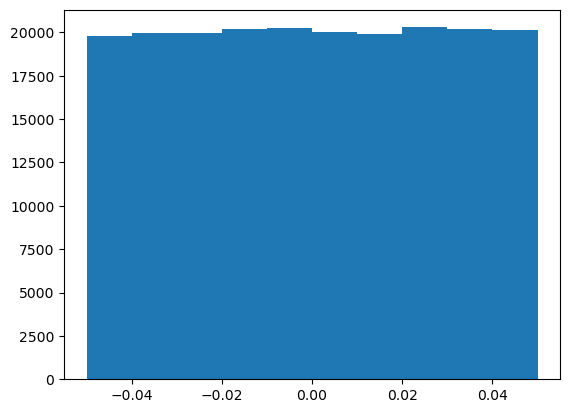

In [27]:
fig = plt.figure()
plt.hist(weights_before_training)

## B1.2 Plot the weights After training

(array([4.6000e+01, 1.5460e+03, 4.1281e+04, 5.3702e+04, 5.3904e+04,
        4.5121e+04, 4.6440e+03, 4.0500e+02, 4.7000e+01, 8.0000e+00]),
 array([-0.10910673, -0.0817735 , -0.05444027, -0.02710704,  0.0002262 ,
         0.02755943,  0.05489266,  0.08222589,  0.10955912,  0.13689235,
         0.16422558]),
 <BarContainer object of 10 artists>)

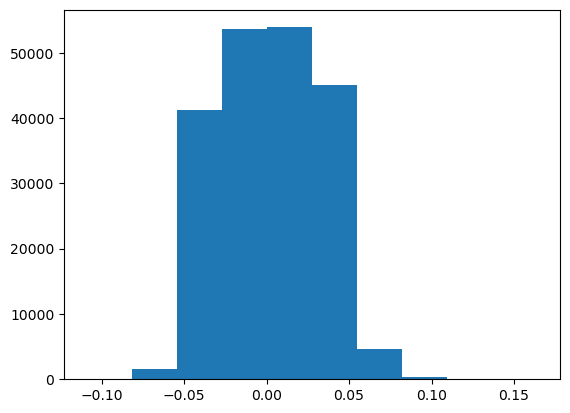

In [28]:
fig = plt.figure()
plt.hist(weights_after_training)

## B1.3 Compare the weights

Construct a plot comparing the weights before fitting to the values after fitting.

##### Hint: You may need to use a log plot in y to see the full distribution(s)

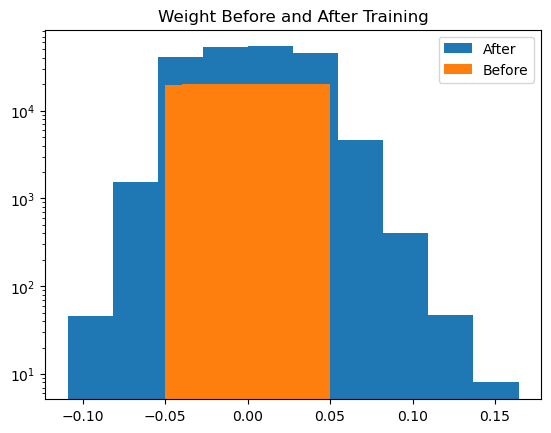

In [29]:
fig = plt.figure()
plt.title('Weight Before and After Training')
plt.hist(weights_after_training,  label='After')
plt.hist(weights_before_training, label='Before')
plt.legend()
plt.yscale('log')

## B1.4 Q: How might the weights vary if you train the model for an additional 80 steps?

### Answer:

### FINISH ME ###

## B1.5 Q: How would inclding a regularizer impact the distribution of weights after training?

### Answer:

### FINISH ME ###

# Bonus 2: Loading a model and optimizing it further

## B2.1 Saving our model

Lets save our model to disk so we can take it home and use it to identify numbers

In [30]:
# saving the model
model_path = './keras_mnist.keras'
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./keras_mnist.keras 


## B2.2 Lets load our model and do some further training

We can load a keras model from disk using the `'load_model'` utility.

In [31]:
# load model
nu_model = load_model('./keras_mnist.keras')
nu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trai

## B2.3 Make some small changes this time

Now we want to try training using the `'Adam'` optimizer so re-compile the model.

(If you re-run model.summary you will find it doesn't need to be re-built)


In [32]:
# compiling the sequential model
nu_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

# Print a helpful summary of our model
nu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trai

## B2.4 Re-Train

We don't have new data to train our model on, but what happens if we continue training with our existing dataset?

Re-train as before with the same data and batch/epoch sizes.

In [ ]:
# training the model and saving metrics in history
nu_history = nu_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=2,
          batch_size=600,
          epochs=30
          )

## B2.5 Evaluating Extended Model Accuracy

Lets make another set of plots to compare how our model accuracy improved with additional training epochs.

In [ ]:
accuracy_training = nu_history.history['accuracy']
accuracy_test = nu_history.history['val_accuracy']

# plotting the metrics
fig = plt.figure()
plt.plot(accuracy_training)
plt.plot(accuracy_test)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

## B2.6 Compare Extended loss functions

As above lets generate some new plots for our loss function evolution

In [ ]:
training_loss = nu_history.history['loss']
validation_loss = nu_history.history['val_loss']

# plotting the metrics
fig = plt.figure()
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

## B2.7 Have we over-trained?

Using the above plots do you think we've now over-trained our model?

### Answer:

### FINISH ME ###